In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats, create_report, latex_table

In [3]:
df = pd.read_csv('../data/processed/structure_prediction_transferability_consolidated_results.csv')
df = df.loc[df.SCOPE.isin(['insider', 'global'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21600 entries, 0 to 21599
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CV_FOLD           21600 non-null  float64
 1   DATA_SOURCE       21600 non-null  object 
 2   METRIC            21600 non-null  object 
 3   MODEL             21600 non-null  object 
 4   SCOPE             21600 non-null  object 
 5   SCORE             21600 non-null  float64
 6   TARGET            21600 non-null  object 
 7   TARGET_ECOREGION  21600 non-null  object 
 8   TRAIN_ECOREGION   21600 non-null  object 
 9   ECOREGION_LABEL   21600 non-null  object 
dtypes: float64(2), object(8)
memory usage: 1.8+ MB


In [4]:
df['MODEL_SCOPE_SOURCE'] = df['MODEL'].str.upper() + '-' + df['SCOPE'].str.upper() + '-' + df['DATA_SOURCE'].str.upper()
df.head()

,CV_FOLD,DATA_SOURCE,METRIC,MODEL,SCOPE,SCORE,TARGET,TARGET_ECOREGION,TRAIN_ECOREGION,ECOREGION_LABEL,MODEL_SCOPE_SOURCE
0,1.0,lidar,rmse,ElasticNet,global,7.528853,total_cover,Blue Mountains,global,Blue Mountains,ELASTICNET-GLOBAL-LIDAR
1,1.0,lidar,nrmse,ElasticNet,global,0.248204,total_cover,Blue Mountains,global,Blue Mountains,ELASTICNET-GLOBAL-LIDAR
2,1.0,lidar,mae,ElasticNet,global,5.490831,total_cover,Blue Mountains,global,Blue Mountains,ELASTICNET-GLOBAL-LIDAR
3,1.0,lidar,mape,ElasticNet,global,0.181016,total_cover,Blue Mountains,global,Blue Mountains,ELASTICNET-GLOBAL-LIDAR
4,1.0,lidar,bias,ElasticNet,global,-2.943946,total_cover,Blue Mountains,global,Blue Mountains,ELASTICNET-GLOBAL-LIDAR


In [80]:
def get_autorank_result(target, metric, **autorank_kwargs):
    work_df = df.loc[(df.METRIC == metric)&(df.TARGET == target)].copy()
    if 'bias' in metric:
        work_df.loc[:,'SCORE'] = abs(work_df.SCORE)
    pivoted = pd.pivot_table(work_df, index=['TARGET_ECOREGION','CV_FOLD'], columns=['MODEL_SCOPE_SOURCE'], values=['SCORE'])
    result = autorank(pivoted['SCORE'], **autorank_kwargs)
    return result

In [81]:
METRICS = ['rmse', 'nrmse', 'mae', 'mape', 'bias', 'rel_bias']
TARGETS = ['total_cover', 'topht', 'qmd', 'tcuft']
results_dict = {target: {metric: None for metric in METRICS} for target in TARGETS}
for target in TARGETS:
    for metric in METRICS:
        result = get_autorank_result(target, metric, order='ascending')
        results_dict[target][metric] = result        

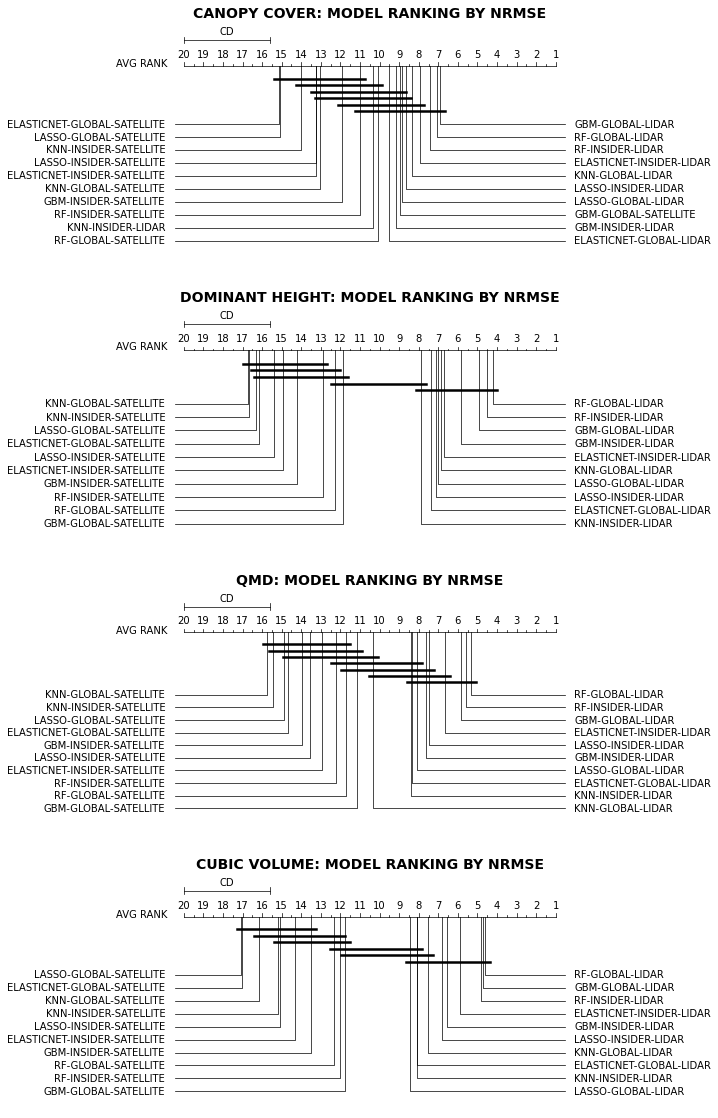

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(10,20))
TARGET_NAMES = ['CANOPY COVER', 'DOMINANT HEIGHT', 'QMD', 'CUBIC VOLUME']
for i, target in enumerate(TARGETS):
    result = results_dict[target]['nrmse']
    plot_stats(result, ax=axs[i])
    axs[i].text(0.045, 0.82, 'AVG RANK', transform=axs[i].transAxes)
    axs[i].set_title(TARGET_NAMES[i] + ': MODEL RANKING BY NRMSE', fontweight='bold', fontsize=14)
plt.savefig('../reports/figures/critical_distances_nrmse_all_targets.png', dpi=450)
plt.show()

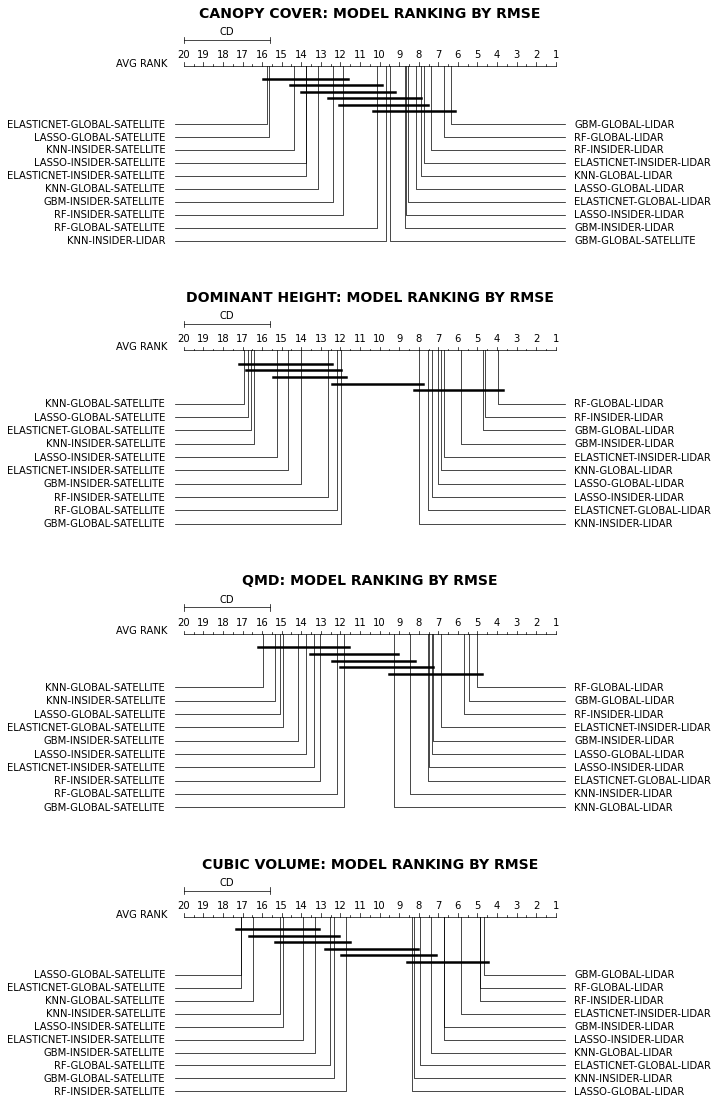

In [11]:
fig, axs = plt.subplots(4, 1, figsize=(10,20))
TARGET_NAMES = ['CANOPY COVER', 'DOMINANT HEIGHT', 'QMD', 'CUBIC VOLUME']
for i, target in enumerate(TARGETS):
    result = results_dict[target]['rmse']
    plot_stats(result, ax=axs[i])
    axs[i].text(0.045, 0.82, 'AVG RANK', transform=axs[i].transAxes)
    axs[i].set_title(TARGET_NAMES[i] + ': MODEL RANKING BY RMSE', fontweight='bold', fontsize=14)
plt.savefig('../reports/figures/critical_distances_rmse_all_targets.png', dpi=450)
plt.show()

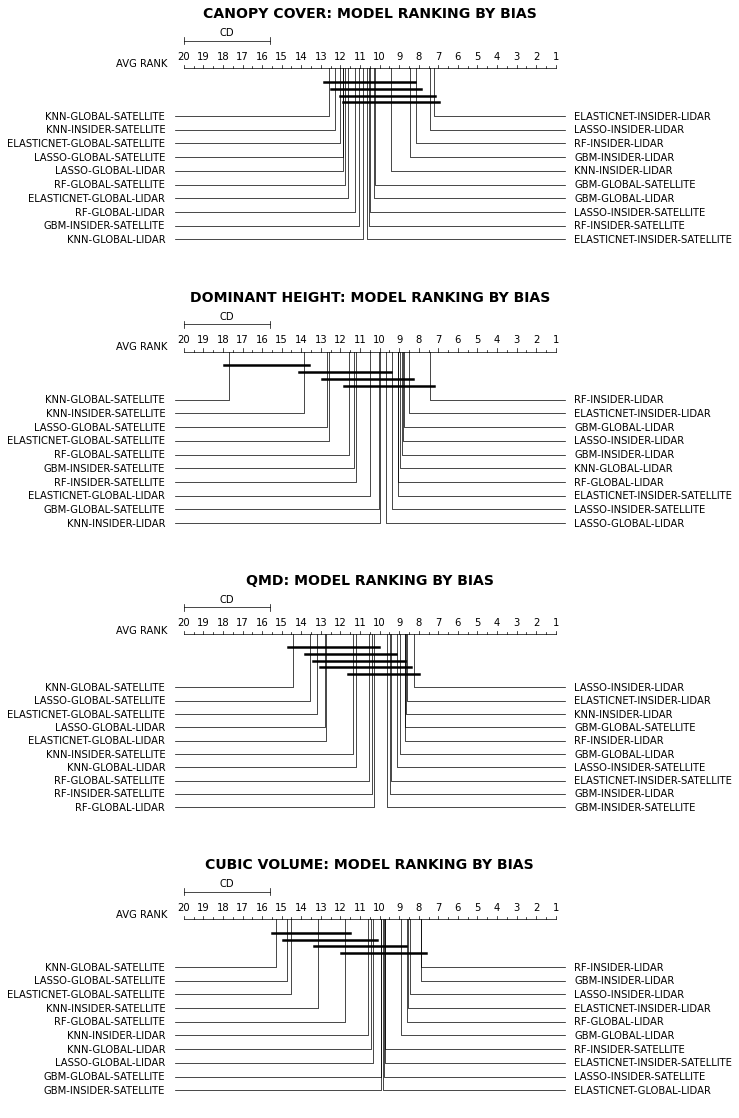

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(10,20))
TARGET_NAMES = ['CANOPY COVER', 'DOMINANT HEIGHT', 'QMD', 'CUBIC VOLUME']
for i, target in enumerate(TARGETS):
    result = results_dict[target]['bias']
    plot_stats(result, ax=axs[i])
    axs[i].text(0.045, 0.82, 'AVG RANK', transform=axs[i].transAxes)
    axs[i].set_title(TARGET_NAMES[i] + ': MODEL RANKING BY BIAS', fontweight='bold', fontsize=14)
plt.savefig('../reports/figures/critical_distances_bias_all_targets.png', dpi=450)
plt.show()

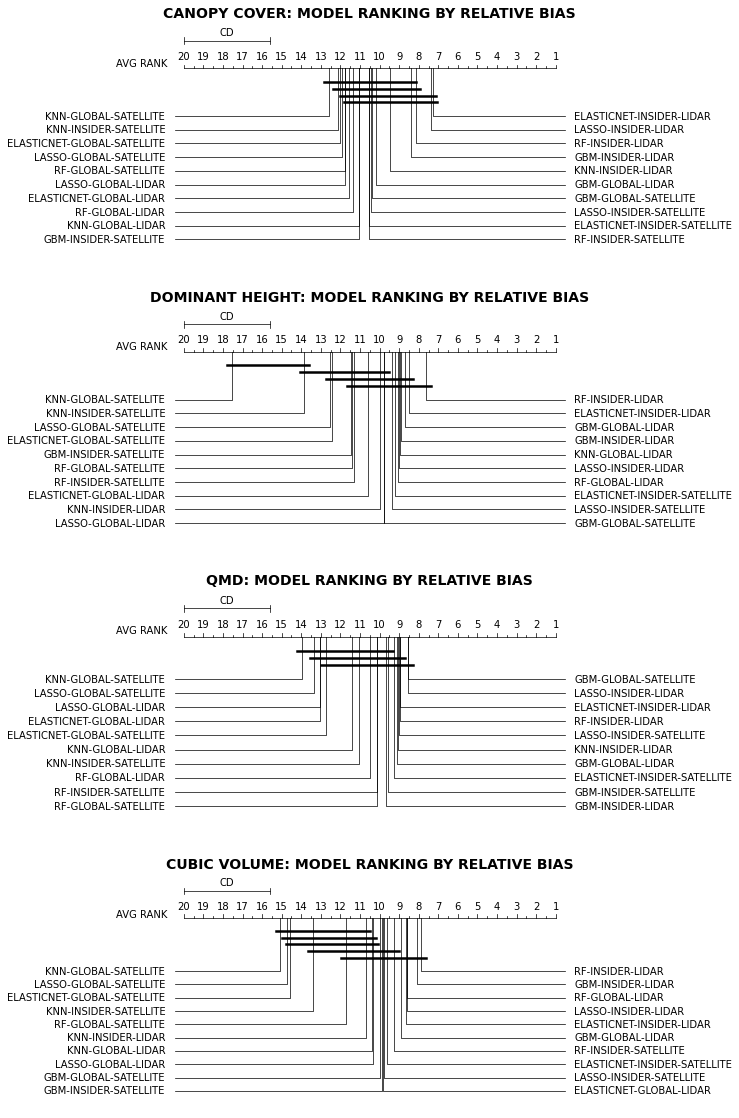

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(10,20))
TARGET_NAMES = ['CANOPY COVER', 'DOMINANT HEIGHT', 'QMD', 'CUBIC VOLUME']
for i, target in enumerate(TARGETS):
    result = results_dict[target]['rel_bias']
    plot_stats(result, ax=axs[i])
    axs[i].text(0.045, 0.82, 'AVG RANK', transform=axs[i].transAxes)
    axs[i].set_title(TARGET_NAMES[i] + ': MODEL RANKING BY RELATIVE BIAS', fontweight='bold', fontsize=14)
plt.savefig('../reports/figures/critical_distances_relative_bias_all_targets.png', dpi=450)
plt.show()

In [12]:
from scipy.stats import median_abs_deviation as mad
full_df = pd.read_csv('../data/processed/structure_prediction_transferability_consolidated_results.csv')
RENAME = {
    'Cascades': 'Western Cascades',
    'Eastern Cascades Slopes And Foothills': 'Eastern Cascades',
    'Klamath Mountains California High North Coast Range': 'Klamath Mountains',    
}
full_df['TARGET_ECOREGION'] = full_df['TARGET_ECOREGION'].replace(RENAME)
met_df = full_df.copy()
ADJ_METS = ['rmse', 'mae', 'bias']
met_df.loc[(met_df.TARGET == 'qmd')&(met_df.METRIC.isin(ADJ_METS)), ['SCORE']] =  met_df.loc[(met_df.TARGET == 'qmd')&(met_df.METRIC.isin(ADJ_METS))]['SCORE'] * 2.54
met_df.loc[(met_df.TARGET == 'topht')&(met_df.METRIC.isin(ADJ_METS)), ['SCORE']] =  met_df.loc[(met_df.TARGET == 'topht')&(met_df.METRIC.isin(ADJ_METS))]['SCORE'] * 0.3048
met_df.loc[(met_df.TARGET == 'tcuft')&(met_df.METRIC.isin(ADJ_METS)), ['SCORE']] =  met_df.loc[(met_df.TARGET == 'tcuft')&(met_df.METRIC.isin(ADJ_METS))]['SCORE'] * 0.0699725

In [90]:
TARGETS = ['total_cover', 'topht', 'qmd', 'tcuft']
SCOPES = ['visitor', 'outsider', 'insider', 'global']
row_idx = pd.MultiIndex.from_product([TARGETS, SCOPES])
SOURCES = ['lidar', 'satellite']
MODELS = ['Lasso', 'ElasticNet', 'kNN', 'RF', 'GBM']
col_idx = pd.MultiIndex.from_product([MODELS, SOURCES])
meds = (pd.pivot_table(met_df.groupby(
    by=['METRIC', 'DATA_SOURCE', 'SCOPE', 'MODEL', 'TARGET'])['SCORE']
                .agg(['median']).loc['rmse'].reset_index(),
                columns=['MODEL', 'DATA_SOURCE'], 
                index=['TARGET', 'SCOPE'], 
                values='median')
.loc[row_idx, col_idx])

mads = (pd.pivot_table(met_df.groupby(
    by=['METRIC', 'DATA_SOURCE', 'SCOPE', 'MODEL', 'TARGET'])['SCORE']
                .agg([mad]).loc['rmse'].reset_index(),
                columns=['MODEL', 'DATA_SOURCE'], 
                index=['TARGET', 'SCOPE'], 
                values='median_abs_deviation')
.loc[row_idx, col_idx])

disp = meds.copy()

med_str = meds.values.round(1).astype(str) 
med_str[-4:] = meds.values[-4:].round(0).astype(int).astype(str)
mad_str = mads.values.round(1).astype(str)
mad_str[-4:] = mads.values[-4:].round(0).astype(int).astype(str)
mad_str = np.char.add(np.full(mads.shape, ' ± ', dtype=mad_str.dtype), mad_str)
disp[:] = np.char.add(med_str, mad_str)
disp

Lasso              ElasticNet              \
                           lidar   satellite       lidar   satellite   
total_cover visitor   23.3 ± 7.6  25.9 ± 6.5  24.7 ± 8.0  24.9 ± 6.1   
            outsider  15.1 ± 1.2  17.6 ± 1.0  15.1 ± 0.4  17.6 ± 1.1   
            insider   14.6 ± 1.5  16.0 ± 1.9  14.5 ± 1.5  16.0 ± 2.0   
            global    14.5 ± 1.0  16.1 ± 1.9  14.7 ± 1.0  16.1 ± 1.9   
topht       visitor    8.4 ± 3.0  12.1 ± 2.8   8.5 ± 3.2  11.6 ± 2.5   
            outsider   5.1 ± 1.1   8.0 ± 1.3   5.2 ± 0.7   7.9 ± 1.2   
            insider    5.1 ± 0.9   7.8 ± 1.5   5.1 ± 0.9   7.8 ± 1.5   
            global     4.4 ± 0.9   7.7 ± 1.3   4.5 ± 1.0   7.6 ± 1.3   
qmd         visitor   15.9 ± 4.0  23.0 ± 4.3  16.8 ± 4.2  22.5 ± 4.8   
            outsider  12.5 ± 1.4  15.0 ± 2.3  12.6 ± 1.0  15.0 ± 1.9   
            insider   12.5 ± 2.4  14.6 ± 3.2  11.5 ± 2.5  14.6 ± 3.2   
            global    11.7 ± 1.9  14.6 ± 2.6  11.7 ± 2.1  14.6 ± 2.6   
tcuft       visitor    376 ± 142   436 ± 114   354 ± 154    442 ± 98   
            outsider    235 ± 73    320 ± 65   231 ± 101    321 ± 57   
            insider     189 ± 68    289 ± 92    194 ± 64    264 ± 91   
            global      194 ± 71    300 ± 75    195 ± 73    300 ± 76   

                             kNN                      RF              \
                           lidar   satellite       lidar   satellite   
total_cover visitor   17.7 ± 2.4  20.5 ± 3.4  17.2 ± 2.2  19.1 ± 2.4   
            outsider  16.0 ± 0.7  16.0 ± 1.2  14.8 ± 0.9  16.5 ± 1.3   
            insider   14.6 ± 1.6  15.8 ± 1.9  14.2 ± 1.4  15.4 ± 1.7   
            global    14.6 ± 1.1  15.7 ± 1.4  14.0 ± 1.4  14.8 ± 2.0   
topht       visitor    6.4 ± 1.4  10.1 ± 1.2   6.0 ± 1.1   9.6 ± 1.4   
            outsider   5.1 ± 0.7   8.5 ± 0.8   4.9 ± 0.8   7.7 ± 1.3   
            insider    5.2 ± 0.8   8.2 ± 1.2   4.6 ± 1.0   7.2 ± 0.9   
            global     4.8 ± 1.1   7.8 ± 1.1   4.2 ± 1.1   6.5 ± 1.2   
qmd         visitor   13.8 ± 1.8  18.9 ± 4.1  13.5 ± 1.7  18.2 ± 3.8   
            outsider  12.6 ± 0.6  16.2 ± 1.4  11.8 ± 0.5  15.8 ± 1.7   
            insider   11.5 ± 2.1  15.5 ± 3.3  10.8 ± 2.7  14.5 ± 2.9   
            global    12.5 ± 2.2  15.4 ± 2.7  11.6 ± 1.8  13.9 ± 2.6   
tcuft       visitor     252 ± 82    372 ± 61    235 ± 78    362 ± 49   
            outsider    228 ± 77    322 ± 65    206 ± 81    297 ± 62   
            insider     199 ± 57    295 ± 75    171 ± 60    250 ± 87   
            global      196 ± 71    288 ± 73    172 ± 59    259 ± 76   

                             GBM              
                           lidar   satellite  
total_cover visitor   17.8 ± 2.0  19.4 ± 2.3  
            outsider  15.3 ± 1.1  16.2 ± 1.2  
            insider   14.3 ± 1.5  15.2 ± 2.1  
            global    13.6 ± 1.5  15.1 ± 1.6  
topht       visitor    6.4 ± 1.2   9.9 ± 1.5  
            outsider   4.8 ± 0.5   7.6 ± 1.4  
            insider    4.9 ± 0.9   7.4 ± 1.1  
            global     4.3 ± 1.0   6.7 ± 1.0  
qmd         visitor   13.6 ± 1.7  18.3 ± 3.7  
            outsider  12.0 ± 1.0  15.2 ± 1.7  
            insider   11.4 ± 2.5  14.8 ± 3.2  
            global    11.4 ± 2.0  13.6 ± 2.4  
tcuft       visitor     250 ± 82    348 ± 50  
            outsider    200 ± 82    282 ± 61  
            insider     188 ± 68    278 ± 78  
            global      179 ± 66    264 ± 86

In [91]:
TARGETS = ['total_cover', 'topht', 'qmd', 'tcuft']
SCOPES = ['visitor', 'outsider', 'insider', 'global']
row_idx = pd.MultiIndex.from_product([TARGETS, SCOPES])
SOURCES = ['lidar', 'satellite']
MODELS = ['Lasso', 'ElasticNet', 'kNN', 'RF', 'GBM']
col_idx = pd.MultiIndex.from_product([MODELS, SOURCES])
means = (pd.pivot_table(met_df.groupby(
    by=['METRIC', 'DATA_SOURCE', 'SCOPE', 'MODEL', 'TARGET'])['SCORE']
                .agg(['mean']).loc['rmse'].reset_index(),
                columns=['MODEL', 'DATA_SOURCE'], 
                index=['TARGET', 'SCOPE'], 
                values='mean')
.loc[row_idx, col_idx])

stds = (pd.pivot_table(met_df.groupby(
    by=['METRIC', 'DATA_SOURCE', 'SCOPE', 'MODEL', 'TARGET'])['SCORE']
                .agg(['std']).loc['rmse'].reset_index(),
                columns=['MODEL', 'DATA_SOURCE'], 
                index=['TARGET', 'SCOPE'], 
                values='std')
.loc[row_idx, col_idx])

disp_means = means.copy()

mean_str = means.values.round(1).astype(str) 
mean_str[-4:] = means.values[-4:].round(0).astype(int).astype(str)
std_str = stds.values.round(1).astype(str)
std_str[-4:] = stds.values[-4:].round(0).astype(int).astype(str)
std_str = np.char.add(np.full(stds.shape, ' ± ', dtype=std_str.dtype), std_str)
disp_means[:] = np.char.add(mean_str, std_str)
disp_means

Lasso                 ElasticNet               \
                             lidar    satellite         lidar    satellite   
total_cover visitor   64.8 ± 125.1  29.9 ± 15.9  66.1 ± 135.9  30.1 ± 16.2   
            outsider    14.8 ± 2.7   16.7 ± 2.5    14.5 ± 3.0   16.7 ± 2.4   
            insider     14.1 ± 3.6   15.6 ± 3.3    13.8 ± 3.5   15.6 ± 3.3   
            global      13.8 ± 3.0   16.0 ± 3.2    13.8 ± 3.0   16.0 ± 3.2   
topht       visitor    14.3 ± 15.9   14.2 ± 7.7   15.3 ± 18.8   13.9 ± 7.6   
            outsider     5.7 ± 1.4    8.2 ± 1.8     5.6 ± 1.4    8.3 ± 1.8   
            insider      5.5 ± 2.2    7.6 ± 2.1     5.1 ± 1.5    7.5 ± 1.9   
            global       4.8 ± 1.3    7.8 ± 1.7     4.8 ± 1.3    7.8 ± 1.7   
qmd         visitor    26.4 ± 33.5  25.2 ± 11.5   22.4 ± 16.9  25.5 ± 11.8   
            outsider    12.9 ± 2.7   17.4 ± 4.6    12.8 ± 2.7   17.4 ± 4.4   
            insider     12.2 ± 3.5   15.8 ± 5.2    11.8 ± 3.5   15.5 ± 4.9   
            global      12.1 ± 3.2   16.1 ± 5.3    12.1 ± 3.2   16.1 ± 5.3   
tcuft       visitor      485 ± 471    490 ± 190     579 ± 910    482 ± 189   
            outsider     235 ± 113     302 ± 91     219 ± 106     306 ± 86   
            insider      202 ± 110    275 ± 135      189 ± 89    262 ± 121   
            global        192 ± 91     287 ± 86      192 ± 92     287 ± 86   

                             kNN                      RF              \
                           lidar   satellite       lidar   satellite   
total_cover visitor   18.4 ± 5.3  20.9 ± 5.2  17.4 ± 4.1  19.6 ± 4.7   
            outsider  14.6 ± 2.8  15.9 ± 2.6  14.0 ± 2.1  15.5 ± 2.9   
            insider   14.6 ± 3.8  15.7 ± 3.1  13.7 ± 3.0  15.1 ± 2.9   
            global    13.6 ± 3.4  15.3 ± 3.4  13.5 ± 2.9  14.5 ± 3.4   
topht       visitor    6.9 ± 2.2  10.6 ± 3.2   6.4 ± 2.3  10.2 ± 3.0   
            outsider   5.4 ± 1.0   8.4 ± 2.0   4.9 ± 1.0   7.4 ± 1.5   
            insider    5.2 ± 1.2   7.8 ± 1.9   4.6 ± 1.3   7.1 ± 1.8   
            global     4.7 ± 1.5   8.0 ± 2.0   4.3 ± 1.4   6.8 ± 1.7   
qmd         visitor   15.0 ± 3.3  19.2 ± 5.5  14.1 ± 3.4  19.4 ± 5.5   
            outsider  13.3 ± 3.0  17.5 ± 4.9  12.2 ± 2.9  17.0 ± 4.9   
            insider   12.2 ± 4.1  16.3 ± 5.3  11.3 ± 3.4  15.4 ± 5.3   
            global    12.7 ± 3.4  16.6 ± 5.7  11.4 ± 3.4  15.1 ± 5.5   
tcuft       visitor    263 ± 132   381 ± 135   251 ± 131   374 ± 135   
            outsider    208 ± 95   289 ± 108    190 ± 90   262 ± 109   
            insider     195 ± 87   272 ± 131    176 ± 81   249 ± 119   
            global      187 ± 91   279 ± 102    170 ± 82   247 ± 105   

                             GBM              
                           lidar   satellite  
total_cover visitor   17.8 ± 3.5  20.4 ± 5.6  
            outsider  14.6 ± 2.7  15.6 ± 2.7  
            insider   14.1 ± 3.1  15.4 ± 2.8  
            global    13.3 ± 3.4  14.4 ± 2.9  
topht       visitor    6.9 ± 2.7  10.4 ± 3.2  
            outsider   5.0 ± 1.1   7.4 ± 1.4  
            insider    4.8 ± 1.2   7.3 ± 1.9  
            global     4.4 ± 1.4   6.7 ± 1.7  
qmd         visitor   14.6 ± 3.5  19.5 ± 5.8  
            outsider  12.4 ± 3.1  16.6 ± 4.5  
            insider   11.9 ± 3.5  15.9 ± 5.2  
            global    11.4 ± 3.5  15.1 ± 5.5  
tcuft       visitor    264 ± 135   364 ± 133  
            outsider    194 ± 96   256 ± 110  
            insider     184 ± 82   262 ± 131  
            global      172 ± 83   244 ± 109

In [83]:
TARGETS = ['total_cover', 'topht', 'qmd', 'tcuft']
effects = {target:None for target in TARGETS}
for target in TARGETS:
    effect = results_dict[target]['rmse'][0]['effect_size'].copy()
    if target == 'qmd':
        effect *= 2.54
    elif target == 'topht':
        effect *= 0.3048
    elif target == 'tcuft':
        effect *= 0.0699725
    effects[target] = effect
effects_df = pd.DataFrame(effects)
effects_df['MODEL'] = [x[0] for x in effects_df.index.str.split('-')]
effects_df['SCOPE'] = [x[1] for x in effects_df.index.str.split('-')]
effects_df['DATA_SOURCE'] = [x[2] for x in effects_df.index.str.split('-')]
effects_df = effects_df.reset_index(drop=True)
melted = pd.melt(effects_df, 
                 id_vars=['MODEL', 'SCOPE', 'DATA_SOURCE'], 
                 value_vars=['total_cover', 'topht', 'qmd', 'tcuft'], 
                 var_name='TARGET', 
                 value_name='EFFECT_SIZE')
melted
# effects_df

,MODEL,SCOPE,DATA_SOURCE,TARGET,EFFECT_SIZE
0,ELASTICNET,GLOBAL,LIDAR,total_cover,-0.795883
1,ELASTICNET,GLOBAL,SATELLITE,total_cover,-1.42225
2,ELASTICNET,INSIDER,LIDAR,total_cover,-0.574819
3,ELASTICNET,INSIDER,SATELLITE,total_cover,-1.33995
4,GBM,GLOBAL,LIDAR,total_cover,0
...,...,...,...,...,...
75,LASSO,INSIDER,SATELLITE,tcuft,-0.0643188
76,RF,GLOBAL,LIDAR,tcuft,0.00142342
77,RF,GLOBAL,SATELLITE,tcuft,-0.0556952
78,RF,INSIDER,LIDAR,tcuft,-0.00318098


In [88]:
melted.set_index(['TARGET', 'SCOPE', 'MODEL', 'DATA_SOURCE']).unstack(['MODEL', 'DATA_SOURCE'])

EFFECT_SIZE                                              \
MODEL                ELASTICNET                   GBM                   KNN   
DATA_SOURCE               LIDAR  SATELLITE      LIDAR  SATELLITE      LIDAR   
TARGET      SCOPE                                                             
qmd         GLOBAL    -0.162533   -3.41385   0.242595   -2.50136   -1.16159   
            INSIDER    0.045132   -3.02716   0.231555   -3.22953  0.0599911   
tcuft       GLOBAL   -0.0163204 -0.0953558          0  -0.052274 -0.0121204   
            INSIDER  -0.0140572 -0.0608656 -0.0101853 -0.0572102 -0.0186507   
topht       GLOBAL   -0.0775536  -0.869015 -0.0373423  -0.735661  -0.167954   
            INSIDER   -0.290455  -0.852852   -0.21368  -0.891552   -0.33763   
total_cover GLOBAL    -0.795883   -1.42225          0  -0.912533  -0.735557   
            INSIDER   -0.574819   -1.33995  -0.447643  -0.864799   -0.65419   

                                                                             
MODEL                               LASSO                     RF             
DATA_SOURCE          SATELLITE      LIDAR  SATELLITE       LIDAR  SATELLITE  
TARGET      SCOPE                                                            
qmd         GLOBAL    -4.24385  -0.215392    -3.4308           0    -2.6601  
            INSIDER   -3.79859   -1.17145   -2.98061    0.868524   -3.10994  
tcuft       GLOBAL  -0.0806437 -0.0165075  -0.095302  0.00142342 -0.0556952  
            INSIDER -0.0639572 -0.0214402 -0.0643188 -0.00318098 -0.0523513  
topht       GLOBAL    -1.01196 -0.0663107  -0.881228           0  -0.611206  
            INSIDER   -1.05171  -0.275907  -0.861639   -0.130013   -0.93119  
total_cover GLOBAL    -1.42558  -0.643525   -1.39896   -0.229653  -0.642641  
            INSIDER   -1.26127  -0.618025   -1.37744   -0.383378   -1.08453

In [89]:
results_dict['qmd']['rmse'][0]

,meanrank,median,mad,ci_lower,ci_upper,effect_size,magnitude
MODEL_SCOPE_SOURCE,,,,,,,
RF-GLOBAL-LIDAR,5.022222,4.551192,0.693435,3.5528,5.66405,0,negligible
GBM-GLOBAL-LIDAR,5.422222,4.480789,0.778356,3.61243,5.65682,0.0955098,negligible
RF-INSIDER-LIDAR,5.711111,4.246914,1.05017,3.1351,5.72493,0.341939,small
ELASTICNET-INSIDER-LIDAR,6.888889,4.536107,0.980089,3.48833,5.9741,0.0177685,negligible
GBM-INSIDER-LIDAR,7.288889,4.474027,0.975739,3.59024,5.90935,0.0911635,negligible
LASSO-GLOBAL-LIDAR,7.333333,4.613069,0.764215,3.59694,6.10805,-0.0848001,negligible
LASSO-INSIDER-LIDAR,7.488889,4.929351,0.929389,3.67717,6.0722,-0.461202,small
ELASTICNET-GLOBAL-LIDAR,7.511111,4.599489,0.811503,3.64606,6.13873,-0.0639892,negligible
KNN-INSIDER-LIDAR,8.422222,4.533200,0.824458,3.7482,6.33765,0.0236185,negligible
